In [ ]:
import matplotlib.pyplot as plt
from cut_simulation.utils.misc import *
from hydra import compose, initialize
from roboninja.env.tc_env import get_cut_env
from roboninja.utils.misc import animate
import pickle


def forward(taichi_env, init_state, comp_actions, grad_enabled, render, **kwargs):
    taichi_env.set_state(init_state, grad_enabled=grad_enabled)

    actions_v = comp_actions[:-1]
    action_p = comp_actions[-1]
    horizon_action = len(actions_v)
    taichi_env.apply_agent_action_p(action_p)
    render_images = list()

    if render: render_images.append(taichi_env.render())
    for i in range(horizon_action):
        taichi_env.step(actions_v[i])
        if render: render_images.append(taichi_env.render())
    loss = taichi_env.get_loss()

    forward_output = {
        'loss': loss,
        'render_images': render_images
    }

    return forward_output


def backward(taichi_env, comp_actions, **kwargs):
    taichi_env.reset_grad()
    taichi_env.get_loss_grad()

    actions_v = comp_actions[:-1]
    horizon_action = len(actions_v)

    for i in range(horizon_action-1, -1, -1):
        taichi_env.step_grad(actions_v[i])
    grad = taichi_env.agent.get_grad(len(actions_v))
    grad[-1][1:] = 0

    backward_output = {
        'grad': grad,
    }

    return backward_output


from hydra.core.global_hydra import GlobalHydra

if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()

initialize(version_base=None, config_path="roboninja/config/cut_env")
cfg = compose(config_name="cut_env")
# cfg = compose(config_name='cut_env')
bone_idx = 0

cfg.strawberry.splat_path = "/path/to/point_cloud.ply"
cfg.strawberry.pos = (0.50, 0.12, 0.50)
cfg.strawberry.scale = (0.18, 0.18, 0.18)

cfg.strawberry.voxelize_res = 256
cfg.strawberry.shell_radius_vox = 2
cfg.strawberry.close_iters = 2
cfg.strawberry.normalize = True
cfg.strawberry.trim_percentile = 0.5
cfg.strawberry.cache_voxels = True
cfg.strawberry.euler = (0.0, 0.0, 0.0)
cfg.auto_boundary = False

cfg.bone.name = f'bone_{bone_idx}'
taichi_env = get_cut_env(cfg)

knife = taichi_env.agent.effectors[0]

# set some constant
horizon_action = 60

# set init actions
init_action_p = np.asarray([-0.8, 0.215, 0.5])
init_action_v = np.asarray([[0., 0., 0.]] * horizon_action)
init_action_v[:int(horizon_action * 0.4), 1] = -0.3
init_actions = np.concatenate([init_action_v, init_action_p[None]], axis=0)

init_state = taichi_env.get_state()['state']
current_actions = init_actions


kwargs = {
    'taichi_env': taichi_env,
    'init_state': init_state,
    'comp_actions': current_actions,
    'grad_enabled': True,
    'render': True
}

[Taichi] Starting on arch=cuda
===> Processing mesh(es) /home/louhz/Desktop/Rss/roboninja/cut_simulation/assets/meshes/raw/knife.obj and vis /home/louhz/Desktop/Rss/roboninja/cut_simulation/assets/meshes/raw/knife.obj.
===> Processed mesh saved as /home/louhz/Desktop/Rss/roboninja/cut_simulation/assets/meshes/processed/knife-knife.obj.
===> Computing sdf for /home/louhz/Desktop/Rss/roboninja/cut_simulation/assets/meshes/raw/knife.obj. This might take minutes...
===> sdf saved as /home/louhz/Desktop/Rss/roboninja/cut_simulation/assets/meshes/processed/knife-128.sdf.
===> Processing mesh(es) /home/louhz/Desktop/Rss/roboninja/cut_simulation/assets/meshes/raw/chopping_board.obj and vis /home/louhz/Desktop/Rss/roboninja/cut_simulation/assets/meshes/raw/chopping_board.obj.
===> Processed mesh saved as /home/louhz/Desktop/Rss/roboninja/cut_simulation/assets/meshes/processed/chopping_board-chopping_board.obj.
===> Processing mesh(es) /home/louhz/Desktop/Rss/roboninja/cut_simulation/assets/mesh

read the strawberry


fix the scale and relative pose for the fruit, scene, obtain the relative final pose for the knife and the strawberry, also compute the knife cutting trajectory with relative to the strawberry 


replace the knife and strawberry and cutting traejectory in the roboninja simulation.

Then simulate the moving of the particel




Then design the custom reward for different strawberry size



 compute the relationship between the knife and the end effector 

 compute ik for different relative pose of the knife and the strawberry and shape of strawberry


 batchify generate data for control


 test it in genesis for collision avoidance


Then add the tactile simulation on the side of this two strawberry and near knife(optional)


 deploy to real world (test the validness of our data, for the rl   )

training logic:  query state(no privilage information)


(based on the verified data)

multi-stage

ee+hand seperate

adaptive chunking size


we have data for the strayberry and hand 


we need more data for the end effector pose varies



render image

[W 01/08/26 04:16:02.172 14202] [vulkan_device.cpp:buffer@620] Overriding last binding
[W 01/08/26 04:16:02.183 14202] [vulkan_device.cpp:buffer@620] Overriding last binding
[W 01/08/26 04:16:02.184 14202] [vulkan_device.cpp:buffer@620] Overriding last binding
[W 01/08/26 04:16:02.185 14202] [vulkan_device.cpp:buffer@620] Overriding last binding


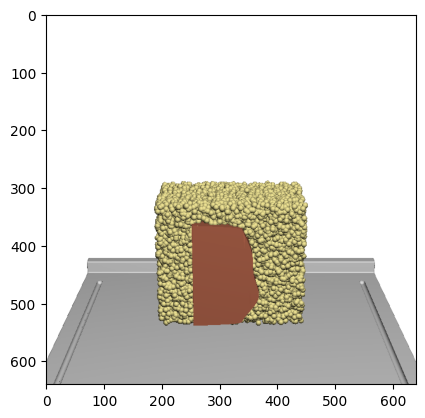

In [3]:
plt.imshow(taichi_env.render())

forward pass using the initial trajectory

In [4]:
forward_output = forward(**kwargs)
print(forward_output['loss'])
animate(forward_output['render_images'], 'videos/initial_trajectory.mp4')

{'loss': 0.18368882543457532, 'cut_loss': 0.015444821408410544, 'collision_loss': 0.0, 'rotation_loss': 0.0, 'move_loss': 0.01454695081967213, 'work_loss': 0.01852394417900178, 'work_curve': array([0., 0., 0., ..., 0., 0., 0.])}


compute action gradient w.r.t. loss

In [5]:
backward_output = backward(**kwargs)
gradient = backward_output['grad']

[W 01/08/26 04:17:25.734 14202] [type_check.cpp:type_check_store@36] [$223103] Local store may lose precision: f32 <- f64

[W 01/08/26 04:17:25.776 14202] [type_check.cpp:type_check_store@36] [$223320] Local store may lose precision: f32 <- f64

[W 01/08/26 04:17:25.824 14202] [type_check.cpp:type_check_store@36] [$223680] Local store may lose precision: f32 <- f64

[W 01/08/26 04:17:26.511 14202] [type_check.cpp:type_check_store@36] [$242944] Local store may lose precision: f32 <- f64

[W 01/08/26 04:17:39.428 14202] [type_check.cpp:type_check_store@36] [$413368] Local store may lose precision: f32 <- f64

[W 01/08/26 04:17:39.428 14202] [type_check.cpp:type_check_store@36] [$413373] Local store may lose precision: f32 <- f64

[W 01/08/26 04:17:39.428 14202] [type_check.cpp:type_check_store@36] [$413378] Local store may lose precision: f32 <- f64

[W 01/08/26 04:17:57.154 14202] [type_check.cpp:type_check_store@36] [$504258] Local store may lose precision: f32 <- f64



directly load the optimized trajectory

In [6]:
data = pickle.load(open(f'data/expert/expert_{bone_idx}/optimization.pkl', 'rb'))
kwargs['comp_actions'] = data[-1]['comp_actions']
forward_output = forward(**kwargs)
animate(forward_output['render_images'], 'videos/optimized_trajectory.mp4')